# ADMM using Julia

In [1]:
using JuMP, OSQP

In [2]:
using Printf, Plots

In [3]:
## Parameters
# costs
cS1 = [10,20]
cS2 = [20,80]

# scenario probability
pi_w = [0.25,0.25,0.25,0.25]

# uncertain parameter
theta = [30,60,70,10]

# bound
alpha_down = -6000;

In [4]:
## Modeling the sub problem (scenario) -- modeling inside a function
function subp(λ,γ,p_da_ave,theta_unc,prob_s)
    # building subproblem model
    sub = Model(OSQP.Optimizer)
    set_silent(sub)
    
    # variables shared by all scenarios
    @variable(sub, 0 ≤ p_da_g1 ≤ 100)
    @variable(sub, 0 ≤ p_da_g2 ≤ 30)
    @variable(sub, 0 ≤ p_da_w ≤ 70)
    # scenarios (exclusive) variables
    @variable(sub, -30 ≤ p_rt_g2 ≤ 30)
    @variable(sub, 0 ≤ p_w_spill ≤ theta_unc)
    @variable(sub, 0 ≤ p_curtail ≤ 120)
    
    # DA energy balance
    @constraint(sub, p_da_g1 + p_da_g2 + p_da_w == 120)

    @constraint(sub, 0 ≤ p_da_g2 + p_rt_g2 ≤ 30)
    @constraint(sub, p_rt_g2 + (theta_unc -  p_da_w - p_w_spill) + p_curtail == 0)
    
    @objective(sub, Min, cS1[1]*p_da_g1 + cS1[2]*p_da_g2 
        + prob_s*(cS2[1]*p_rt_g2 + cS2[2]*p_curtail) 
        + λ[1]*p_da_g1 + λ[2]*p_da_g2 + λ[3]*p_da_w
        + γ/2*((p_da_g1 - p_da_ave[1])^2 + (p_da_g2 - p_da_ave[2])^2 + (p_da_w - p_da_ave[3])^2)
        )
    #print(sub)
    #@show sub
    
    optimize!(sub)
    #a = termination_status(sub)
    
    #calling values of the solved subproblem
    o = objective_value(sub)
    g1 = value(p_da_g1)
    g2 = value(p_da_g2)
    w = value(p_da_w)
    sp = value(p_w_spill)
    cu = value(p_curtail)
    g2rt = value(p_rt_g2)
    
    return Dict('o' => o, 'g' => g1, 'r' => g2, 'w' => w, 's' => sp, 'c' => cu, 'a' => g2rt)
end


subp (generic function with 1 method)

In [5]:
#subp([90,30,0],10,0.25)

In [6]:
function print_iteration(k, args...)
    f(x) = Printf.@sprintf("%12.4e",x)
    println(lpad(k,9), " ",join(f.(args), " "))
    return
end

print_iteration (generic function with 1 method)

In [7]:
println("k  p_da_g1  p_da_g2  p_da_w")

# initial guess for the multipliers
λᵏ = ones(4,3) # numS, numG

# learning rate (same for all)
γᵏ = 0.3

# initial guess for the average
p_da_g_bar = [90, 30, 0]

# number of iterations
nIter = 100

# plotting residuals
p = plot(xlabel="iteration", ylabel="Residual", yaxis=:log)

for k in 1:nIter   

    # solve subproblems --- subp(λ,γ,p_da_ave,theta_unc,prob_s)
    # computing the average
    p_da_g1_bar = sum(subp(λᵏ[ii,:],γᵏ,p_da_g_bar,theta[ii],pi_w[ii])['g'] for ii in 1:4)/4
    p_da_g2_bar = sum(subp(λᵏ[ii,:],γᵏ,p_da_g_bar,theta[ii],pi_w[ii])['r'] for ii in 1:4)/4
    p_da_w_bar = sum(subp(λᵏ[ii,:],γᵏ,p_da_g_bar,theta[ii],pi_w[ii])['w'] for ii in 1:4)/4
    
    # recomputing the average with the most updated information
    p_da_g_bar = [p_da_g1_bar, p_da_g2_bar, p_da_w_bar]
    
    # updating the dual info
    for ii in 1:4
        λᵏ[ii,1] = λᵏ[ii,1] + γᵏ*(subp(λᵏ[ii,:],γᵏ,p_da_g_bar,theta[ii],pi_w[ii])['g'] - p_da_g_bar[1])
        λᵏ[ii,2] = λᵏ[ii,2] + γᵏ*(subp(λᵏ[ii,:],γᵏ,p_da_g_bar,theta[ii],pi_w[ii])['r'] - p_da_g_bar[2])
        λᵏ[ii,3] = λᵏ[ii,3] + γᵏ*(subp(λᵏ[ii,:],γᵏ,p_da_g_bar,theta[ii],pi_w[ii])['w'] - p_da_g_bar[3])
    end

    # compute optimality gap
    res_g1ᵏ = sum((subp(λᵏ[ii,:],γᵏ,p_da_g_bar,theta[ii],pi_w[ii])['g'] - p_da_g1_bar)^2 for ii in 1:4)
    res_g2ᵏ = sum((subp(λᵏ[ii,:],γᵏ,p_da_g_bar,theta[ii],pi_w[ii])['r'] - p_da_g2_bar)^2 for ii in 1:4)
    res_wᵏ = sum((subp(λᵏ[ii,:],γᵏ,p_da_g_bar,theta[ii],pi_w[ii])['w'] - p_da_w_bar)^2 for ii in 1:4)
           
    if k == nIter
        # plotting without legend  
        plot!([k],[res_g1ᵏ], marker=:circle,  markercolor = :green, label="p_g1")
        plot!([k],[res_g2ᵏ], marker=:square, markercolor = :red, label="p_g2")
        plot!([k],[res_wᵏ], marker=:circle, markercolor = :black, label="p_w")
    
        println(" **** solution found ********")
        println("p_da_g1  p_da_g2  p_da_w")
        print_iteration(k, p_da_g1_bar,p_da_g2_bar,p_da_w_bar)
        
        println("s  p_rt_g2  p_spill  p_curt")
        for wi in 1:4
            rt = subp(λᵏ[wi,:],γᵏ,p_da_g_bar,theta[wi],pi_w[wi])['a']
            spill = subp(λᵏ[wi,:],γᵏ,p_da_g_bar,theta[wi],pi_w[wi])['s']
            curt = subp(λᵏ[wi,:],γᵏ,p_da_g_bar,theta[wi],pi_w[wi])['c']
            print_iteration(wi,rt,spill,curt)
        end
        
        #display(λᵏ)
    else
        # plotting without legend    
        plot!([k],[res_g1ᵏ], marker=:circle,  markercolor = :green, label="")
        plot!([k],[res_g2ᵏ], marker=:square, markercolor = :red, label="")
        plot!([k],[res_wᵏ], marker=:circle, markercolor = :black, label="")
            
        # print iteration information
        print_iteration(k,res_g1ᵏ,res_g2ᵏ,res_wᵏ)
    end
end

k  p_da_g1  p_da_g2  p_da_w
        1   4.8089e+00   1.2962e+02   1.1609e+02
        2   1.6855e+00   8.1330e-05   1.6978e+00
        3   1.0538e-01   5.2451e-05   1.0589e-01
        4   6.9458e-03   4.7715e-05   6.6670e-03
        5   3.6342e-04   4.9124e-05   4.5933e-04
        6   3.5364e-05   4.9005e-05   5.9214e-04
        7   1.1859e-04   4.9104e-05   6.2681e-05
        8   2.4957e-05   5.2593e-05   5.9862e-06
        9   2.2762e-05   4.9173e-05   5.7914e-06
       10   2.1997e-05   4.6923e-05   5.4232e-06
       11   1.1565e-03   4.9043e-05   9.3466e-05
       12   5.3073e-04   5.2420e-05   4.5137e-04
       13   5.4431e-04   4.9019e-05   5.4705e-06
       14   2.3251e-05   4.9024e-05   6.0569e-06
       15   2.1825e-05   4.9051e-05   5.4603e-06
       16   2.1826e-05   5.6496e-05   5.4595e-06
       17   2.1835e-05   5.2525e-05   5.4617e-06
       18   2.6010e-05   4.9092e-05   6.0136e-06
       19   1.3797e-04   4.9118e-05   9.6691e-05
       20   3.2267e-05   4.9213e-05   9.6

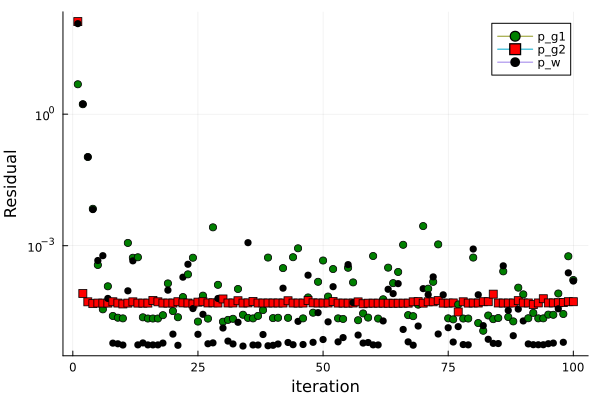

In [8]:
display(p)

In [9]:
#print(master)